In [99]:
# !pip install update xarray 
# !pip install cmocean 
# ! pip install netcdf4
# ! pip install cftime
# ! pip install hdf5
# !  pip install nc-time-axis
# ! pip install wget
# ! pip install matplotlib
# ! pip install intake
# ! pip  install zarr
# ! pip install dask
# ! pip install tqdm
# ! pip install nc_time_axis
# ! pip install cmip6_preprocessing
# ! pip install gcsfs
# ! apt-get -qq install python-cartopy python3-cartopy
# ! python -m pip install intake-esm
# ! conda install -c conda-forge xesmf esmpy=7.1.0 --y
! pip install --upgrade git+https://github.com/JiaweiZhuang/xESMF.git@area



  Cloning https://github.com/JiaweiZhuang/xESMF.git (to revision area) to /tmp/pip-req-build-nggxkwyg
  Running command git clone -q https://github.com/JiaweiZhuang/xESMF.git /tmp/pip-req-build-nggxkwyg
  Running command git checkout -b area --track origin/area
  Switched to a new branch 'area'
  Branch 'area' set up to track remote branch 'area' from 'origin'.
  Created wheel for xesmf: filename=xesmf-0.1.1-py3-none-any.whl size=17755 sha256=e249abdda1d8fab64dc74b9f21cd2dd966676bd695c2ce5b0f52b541867d1ec9
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1q760sd/wheels/57/8f/f9/97ab98394f88487225ee429135fcbce672b38efa74874ef860
Successfully built xesmf
  Attempting uninstall: xesmf
    Found existing installation: xesmf 0.3.0
    Uninstalling xesmf-0.3.0:
      Successfully uninstalled xesmf-0.3.0


In [3]:
%matplotlib inline
import numpy as np
import gcsfs
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import intake_esm
# import cartopy
# from cartopy import util
# import cartopy.crs as ccrs
import zarr
import dask.array as da  
from dask.diagnostics import ProgressBar
from tqdm.autonotebook import tqdm
import nc_time_axis
import time
import xesmf as xe
import cmip6_preprocessing
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [4]:
from cmip6_preprocessing.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon, rename_cmip6

def wrapper(ds):
    ds = ds.copy()
    #ds = rename_cmip6(ds)
    #ds = replace_x_y_nominal_lat_lon(ds)
    
    if ('longitude' in ds.dims):
        ds = ds.rename({'longitude':'lon'}) # some models labelled dimensions differently...
    if ('latitude' in ds.dims):    
        ds = ds.rename({'latitude': 'lat'})

    #------------experimental---------- 
    
    if ('nav_lon' in ds.dims):
        ds = ds.rename({'nav_lon':'lon'}) # some models labelled dimensions differently...
    if ('nav_lat' in ds.dims):    
        ds = ds.rename({'nav_lat': 'lat'})
    if ('vertices' in ds.dims): 
        ds=ds.drop_dims('vertices')   
    if ('nvertex' in ds.dims): 
        ds=ds.drop_dims('nvertex') 
    if ('axis_nbounds' in ds.dims): 
        ds=ds.drop_dims('axis_nbounds')       
    #-----------------------------------    
        
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height')
    if ('depth' in ds): 
        ds=ds.drop_vars('depth')
    return ds


def addCyclicPoint(xarray_obj, dim, period=None):
    """
    Add a cyclic longitude point for data that doesn't wrap back to zero. Avoids seam at 0 or 180 longitude
    """
    if period is None:
        period = xarray_obj.sizes[dim] * xarray_obj.coords[dim][:2].diff(dim).item()
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
                                    
    return xr.concat([xarray_obj, first_point], dim=dim)


ds_out = xe.util.grid_global(1, 1)



In [102]:
import xesmf as xe

area = xe.util.cell_area(ds_out)

AttributeError: module 'xesmf.util' has no attribute 'cell_area'

In [14]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


variable_id = 'fgco2' #@param {type:"string"}
table_id = 'Omon' #@param {type:"string"}
member_id = 'r1i1p1f1'

dset_dicts={}  #==dset_dicts_match 
experiment_ids=['historical','ssp126', 'ssp245', 'ssp585']

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

for exp in experiment_ids:
    model_dict={}   #==dset_dicts_proc 
    canesm5_query = df.query(f"table_id == '{table_id}' & "\
                            f"variable_id == '{variable_id}' & "\
                            f"experiment_id == '{exp}' & "\
                            f"member_id == '{member_id}'")
                            


    for zstore in canesm5_query.zstore.values:
        
        model = zstore.split('/')[6]
        mapper = gcs.get_mapper(zstore)
        temp = xr.open_zarr(mapper, consolidated=True)
        ds = wrapper(temp)
        
        try:
            ds = ds.rename({'longitude':'lon', 'latitude':'lat'}) 
              
        except:     
            pass
        
        try:
            ds = ds.rename({'nav_lat':'lat', 'nav_lon':'lon'})
            
        except:
            pass
            
        try:
            regridder = xe.Regridder(ds, ds_out, 'bilinear', ignore_degenerate=True, reuse_weights=True, periodic=True)
            ds = regridder(ds.fgco2)
            temp = ds.where((ds.lat[:]>10), drop= True)
            temp = temp.where((temp.lon[:]>-155) & (temp.lon[:]<-30), drop= True)

        except:
            print('Failed:', model)
            temp = ds
        
        model_dict[model] = temp

    dset_dicts[exp] = model_dict

Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_332x362_180x360_peri.nc
Reuse existing file: bilinear_232x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_232x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_291x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_220x256_180x360_peri.nc
Reuse existing file: bilinear_404x802_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_220x256_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_384x320_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_385x360_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_384x320_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_385x360_180x360_peri.nc
Reuse existing file: bilinear_300x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_232x360_180x360_peri.nc
Reuse existing file: bilinear_291x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/e

Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_404x802_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_220x256_180x360_peri.nc
Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_332x362_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_385x360_180x360_peri.nc
Reuse existing file: bilinear_300x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_332x362_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_232x360_180x360_peri.nc
Failed: CanESM5
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_404x802_180x360_peri.nc
Reuse existing file: bilinear_220x256_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_300x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_232x360_180x360_peri.nc
Reuse existing file: bilinear_291x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/e

Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_220x256_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_404x802_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_332x362_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_385x360_180x360_peri.nc
Reuse existing file: bilinear_300x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [6]:
for exp in experiment_ids:
    model_dict={}   #==dset_dicts_proc 
    canesm5_query = df.query(f"table_id == '{table_id}' & "\
                            f"variable_id == '{variable_id}' & "\
                            f"experiment_id == '{exp}' & "\
                            f"member_id == '{member_id}'")
                            


    for zstore in canesm5_query.zstore.values:
        print(zstore)

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/fgco2/gr/v20180701/
gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Omon/fgco2/gn/v20180803/
gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Omon/fgco2/gn/v20181126/
gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/Omon/fgco2/gn/v20181129/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/fgco2/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/fgco2/gr/v20190308/
gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Omon/fgco2/gn/v20190429/
gs://cmip6/CMIP6/CMIP/INM/INM-CM4-8/historical/r1i1p1f1/Omon/fgco2/gr1/v20190530/
gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical/r1i1p1f1/Omon/fgco2/gr1/v20190610/
gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Omon/fgco2/gn/v20190627/
gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Omon/fgco2/gn/v20190710/
gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Omon/fgco2/gn/v

In [15]:
#fixong naming inconsitency

# z_fix = ['gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/fgco2/gr/',
#         'gs://cmip6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/fgco2/gr/',
#         'gs://cmip6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Omon/fgco2/gn/']

# for zstore in z_fix:

#     model = zstore.split('/')[5]
#     mapper = gcs.get_mapper(zstore)
#     temp = xr.open_zarr(mapper, consolidated=True)
#     ds = wrapper(temp)

#     try:
#         ds = ds.rename({'longitude':'lon', 'latitude':'lat'}) 

#     except:     
#         pass

#     try:
#         ds = ds.rename({'nav_lat':'lat', 'nav_lon':'lon'})

#     except:
#         pass

#     try:
#         regridder = xe.Regridder(ds, ds_out, 'bilinear', ignore_degenerate=True, reuse_weights=True, periodic=True)
#         temp = regridder(ds.fgco2)
#     except:
#         print('Failed:', model)
#         temp = ds

#     dset_dicts['historical'][model] = temp
    
# del dset_dicts['historical']['historical']


# ValueError: destination buffer too small; expected at least 838080, got 419040 only for CanESM5 ssp245

del dset_dicts['ssp245']['CanESM5']


In [16]:
# keep only models with historical run
dset_dicts_match = {}
dset_dicts_match['historical'] = dset_dicts['historical']
    
experiment_ids=['ssp126', 'ssp245', 'ssp585']

for exp in experiment_ids:
    tmp = {}
    for name, data in dset_dicts[exp].items():
        if name in dset_dicts['historical'].keys(): 
            tmp[name] = data
    dset_dicts_match[exp] = tmp         

In [17]:
del dset_dicts_match['historical']['BCC-CSM2-MR']
del dset_dicts_match['historical']['BCC-ESM1']
del dset_dicts_match['historical']['GISS-E2-1-G-CC']
del dset_dicts_match['ssp126']['BCC-CSM2-MR']
del dset_dicts_match['ssp245']['BCC-CSM2-MR']
del dset_dicts_match['ssp585']['BCC-CSM2-MR']

In [34]:
timeseries_dicts = {}
# Simple cos(lat) weighted global means. Using areacella would be better, but not available on GCP for many models.
for exp, dic in tqdm(dset_dicts_match.items()):
    tmp = {}
    for model, data in dic.items():
        cos_lat_2d = np.cos(np.deg2rad(data.lat))
        tmp[model] = ((data * cos_lat_2d).sum(dim=['x', 'y'])/cos_lat_2d.sum(dim=['y','x']))
    timeseries_dicts[exp] = tmp 

  0%|          | 0/4 [00:00<?, ?it/s]

In [91]:
fgco2_anom_timeseries = {}
for exp, dic in timeseries_dicts.items():
    tmp = {}
    for model, data in dic.items():
               tmp[model] = ((data.sel(time=slice('1850','2100')) - timeseries_dicts['historical'][model].sel(time=slice('1850','1900')).mean(dim='time')).groupby('time.year').mean(dim='time'))* sec_2_yr

    
    fgco2_anom_timeseries[exp] = tmp 

In [37]:
sec_2_yr = 60*60*24*365
kg_2_mol = 1000./12.
kgs_2_pgyr = sec_2_yr / 1e12

In [92]:
fgco2_anoms_ts = {}
for exp, dic in fgco2_anom_timeseries.items():
    dss = [ds for key, ds in dic.items()]
    fgco2_anoms_ts[exp] = xr.concat(dss, dim='source_id').assign_coords(source_id=list(dic.keys()))

In [93]:
upper_bounds = {}
lower_bounds = {}
for key, data in fgco2_anoms_ts.items():
    upper_bounds[key] = (data.mean(dim='source_id') + 
                         data.std(dim='source_id')*2.0).squeeze()
    lower_bounds[key] = (data.mean(dim='source_id') -
                         data.std(dim='source_id')*2.0).squeeze()

KeyboardInterrupt: 

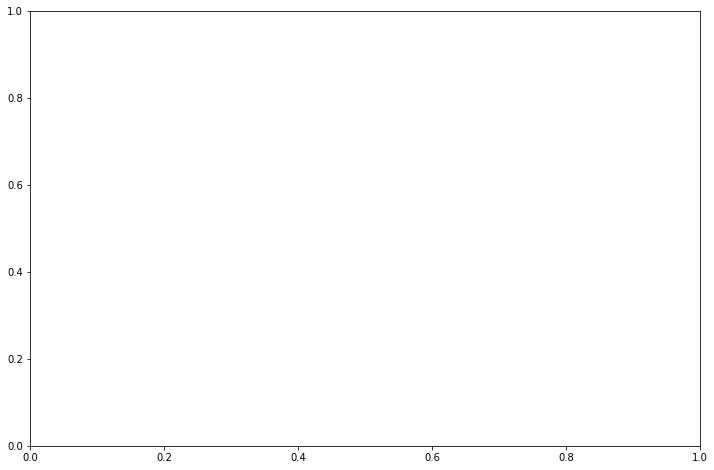

In [94]:
%%time
fig, ax = plt.subplots(1,1,figsize=(12,8))

colors = ['k', 'tab:cyan', 'tab:blue', 'darkorange', 'tab:red']
label = ['historical', 'SSP126', 'SSP245', 'SSP585']
for i, key in enumerate(['historical', 'ssp126', 'ssp245', 'ssp585']):
    ax.fill_between(fgco2_anoms_ts[key].year, upper_bounds[key], lower_bounds[key], 
                    facecolor=colors[i], alpha=0.3)

    ax.plot(fgco2_anoms_ts[key].year, fgco2_anoms_ts[key].mean(dim='source_id'), 
            color=colors[i], label=label[i])
    

ax.legend(frameon=False, loc='upper left')
ax.set_ylabel('fgco2 anomaly (kg m$^{-2}$ yr$^{-1}$)')
ax.set_xlabel('Year')
ax.set_xlim([1850, 2100])


ax.set_title('CMIP6 mean anomalies relative to 1850-1900')
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='both', left=True, right=True, which='both', direction='in')


# maps

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Multi Model mean flux anomaly 2015-2050 ssp585 to 1850-1900 mean')

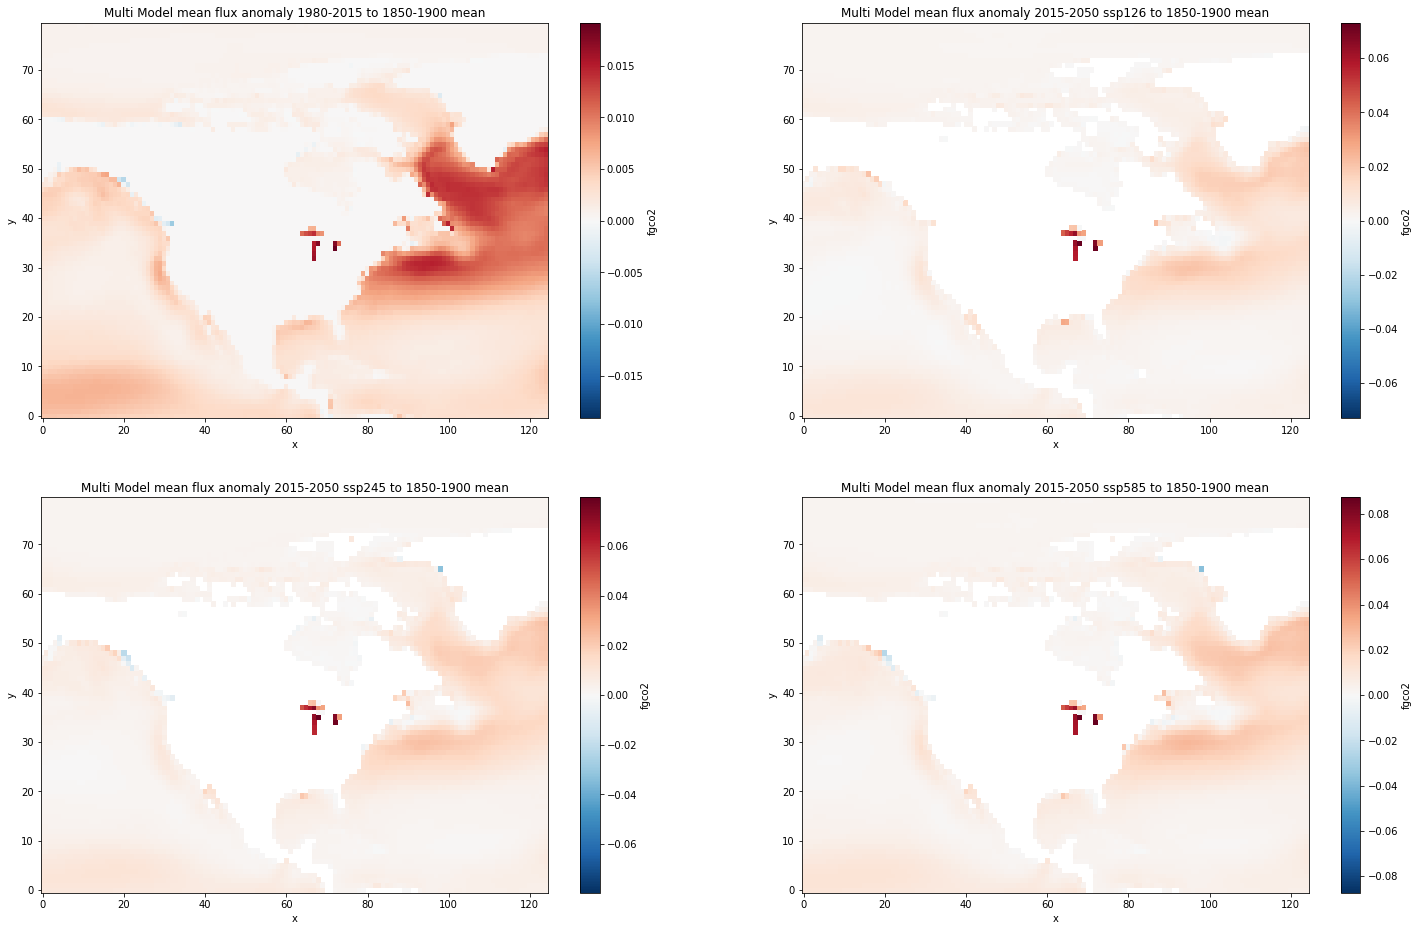

In [44]:
fgco2_anom_dicts = {}
for exp, dic in dset_dicts_match.items():
    tmp = {}
    if exp == 'historical':
          for model, data in dic.items():
              try:
                  tmp[model] = data.sel(time=slice('1980','2015')).mean(dim='time') - dset_dicts_match['historical'][model].sel(time=slice('1850','1900')).mean(dim='time')
                               
              except:
                  print('Failed:', model)
    else:

          for model, data in dic.items():
              try:
                  tmp[model] = data.sel(time=slice('2015','2050')).mean(dim='time') - dset_dicts_match['historical'][model].sel(time=slice('1850','1900')).mean(dim='time')
                               
              except:
                  print('Failed:', model)

    fgco2_anom_dicts[exp] = tmp 
    
    
fgco2_anoms = {}
for exp, dic in fgco2_anom_dicts.items():
    dss = [ds for key, ds in dic.items()]
    fgco2_anoms[exp] = xr.concat(dss, dim='source_id').assign_coords(source_id=list(dic.keys())).load()


fig= plt.figure(figsize=(25,16))

ax = plt.subplot(2,2,1)
cb= (fgco2_anoms['historical'].mean(dim='source_id')*sec_2_yr).plot()
#  _=ax.coastlines()
ax.set_title('Multi Model mean flux anomaly 1980-2015 to 1850-1900 mean')
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')


ax = plt.subplot(2,2,2)
cb= (fgco2_anoms['ssp126'].mean(dim='source_id')*sec_2_yr).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp126 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')



ax = plt.subplot(2,2,3)
cb= (fgco2_anoms['ssp245'].mean(dim='source_id')*sec_2_yr).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp245 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')


ax = plt.subplot(2,2,4)
cb= (fgco2_anoms['ssp585'].mean(dim='source_id')*sec_2_yr).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp585 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')